<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/3.%20Random%20Forest/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №5. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [14]:
# Подключаем необходимые библиотеки для работы с данными и визуализации
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import os

## 2. Импортируем датасет

In [16]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('/content/train.csv')

Saving train.csv to train.csv


In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 4. Сформируем обучающую и тестовую выборки:


In [19]:
# Заполним пропуски средним значением
df['Age'].fillna(df['Age'].mean(), inplace=True)

<ipython-input-19-2c2329f24d62>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)


In [20]:
from sklearn.model_selection import train_test_split

X = df.drop(['Survived', 'Name'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((596, 10), (596,), (295, 10), (295,))

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [21]:
X_train.dtypes

,0
PassengerId,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object
Embarked,object


In [23]:
!pip install category_encoders

In [24]:
import category_encoders as ce

In [25]:
# Закодируем значения категориальных признаков в числовой формат
encoder = ce.OrdinalEncoder(cols=['Sex', 'Ticket', 'Cabin', 'Embarked'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [26]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,1,1,54.000000,0,0,1,51.8625,1,1
718,719,3,1,29.699118,0,0,2,15.5000,105,2
685,686,2,1,25.000000,1,2,3,41.5792,105,3
73,74,3,1,26.000000,1,0,4,14.4542,105,3
882,883,3,2,22.000000,0,0,5,10.5167,105,1


In [27]:
X_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,3,1,29.699118,1,1,-1.0,15.2458,105.0,3
439,440,2,1,31.000000,0,0,-1.0,10.5000,105.0,1
840,841,3,1,20.000000,0,0,-1.0,7.9250,105.0,1
720,721,2,2,6.000000,0,1,234.0,33.0000,105.0,1
39,40,3,2,14.000000,1,0,147.0,11.2417,105.0,3


## 6. Построение базовой модели:

In [28]:
rfc = RandomForestClassifier(n_estimators=10, random_state=1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

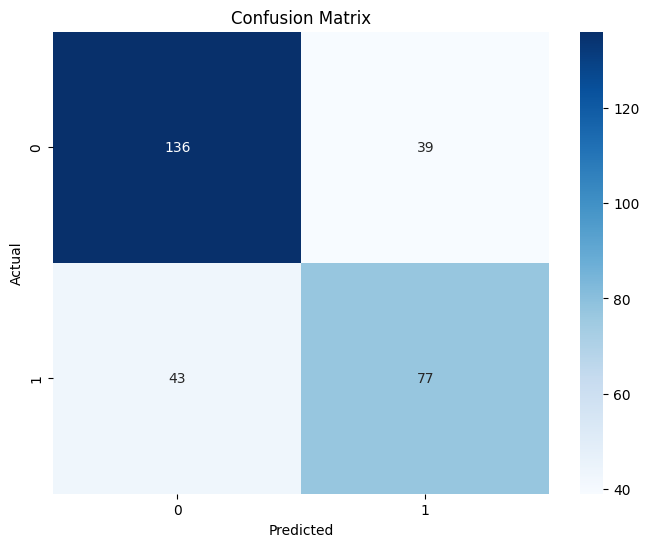

In [33]:
def rfc_m (y_test, y_pred_1):
    cm_1 = confusion_matrix(y_test, y_pred_1)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_1, annot=True, fmt=".0f", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

y_pred_1 = rfc.predict(X_test)
rfc_m (y_test, y_pred_1)

In [34]:
# classification_report - для оценки производительности моделей машинного обучения.
# Основные метрики, которые включаются в классификационный отчёт: точность, отзыв, оценка F1 и поддержка для каждого класса.
# 1. Точность — отношение правильно предсказанных положительных наблюдений к общему количеству предсказанных положительных значений.
# 2. Отзыв (чувствительность) — отношение правильно предсказанных положительных наблюдений ко всем фактическим положительным значениям.
# 3. Оценка F1 — взвешенное гармоническое среднее точности и отзыва. Чем ближе значение оценки F1 к 1, тем лучше работает модель.
# 4. Поддержка — количество фактических появлений класса в указанном наборе данных.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       175
           1       0.66      0.64      0.65       120

    accuracy                           0.72       295
   macro avg       0.71      0.71      0.71       295
weighted avg       0.72      0.72      0.72       295



### 7.2. Оцените точность модели:

In [35]:
from sklearn.metrics import accuracy_score

print('Оценка точности модели при использовании 10 деревьев решений : {0:0.4f}'. format(accuracy_score(y_test, y_pred_1)))

Оценка точности модели при использовании 10 деревьев решений : 0.7220


## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# Определяем список значений для параметра n_estimators (количество деревьев в лесу)
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# Определяем список значений для параметра max_depth (максимальная глубина дерева)
max_depth = [int(x) for x in np.linspace(3, 50, num=5)]
max_depth.append(None)  # Добавляем значение None для отсутствия ограничения глубины

# Определяем список значений для параметра max_leaf_nodes (максимальное количество листовых узлов)
max_leaf_nodes = [int(i) for i in range(1, 100)]

# Определяем пространство гиперпараметров для случайного поиска
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

# Создаем модель классификатора случайного леса с фиксированным random_state для воспроизводимости
rf_clf = RandomForestClassifier(random_state=1)

# Инициализируем RandomizedSearchCV для поиска оптимальных гиперпараметров
rf_cv = RandomizedSearchCV(
    estimator=rf_clf,                # модель для настройки
    param_distributions=random_grid, # словарь с параметрами для случайного поиска
    n_iter=100,                      # количество итераций (случайных наборов гиперпараметров)
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=5,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    random_state=42,                 # фиксированный сид для воспроизводимости результатов
    n_jobs=-1                        # использование всех доступных ядер процессора
)

# Обучаем модель RandomizedSearchCV на обучающих данных с перебором гиперпараметров
rf_cv.fit(X_train, y_train)

# Получаем оптимальные гиперпараметры после поиска
rf_best_params = rf_cv.best_params_
print(f"Лучшие параметры: {rf_best_params}")

# Создаем новый классификатор случайного леса с оптимальными гиперпараметрами
rf_clf = RandomForestClassifier(**rf_best_params)

# Обучаем модель с оптимальными гиперпараметрами на обучающих данных
rf_clf.fit(X_train, y_train)

# Предсказываем классы для тестовых данных
y_pred_2 = rf_clf.predict(X_test)

# Выводим оценку точности модели на тестовых данных
print('Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Лучшие параметры: {'n_estimators': 40, 'max_leaf_nodes': 57, 'max_depth': 26}
Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: 0.7220


GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

# Определяем список значений для параметра n_estimators (количество деревьев)
n_estimators = [int(i) for i in range(1, 15)]

# Определяем список значений для параметра max_depth (максимальная глубина дерева)
max_depth = [5, 10, 15]
max_depth.append(None)  # Добавляем значение None для отсутствия ограничения глубины

# Определяем список значений для параметра max_leaf_nodes (максимальное количество листьев)
max_leaf_nodes = [int(i) for i in range(1, 30)]

# Создаем словарь с параметрами для перебора в GridSearchCV
params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

# Инициализируем классификатор случайного леса с фиксированным random_state для воспроизводимости
rf_clf = RandomForestClassifier(random_state=0)

# Настраиваем GridSearchCV для поиска наилучших гиперпараметров
rf_cv = GridSearchCV(
    estimator=rf_clf,        # модель для настройки
    param_grid=params_grid,  # словарь с параметрами для перебора
    scoring="accuracy",      # метрика для оценки качества моделей
    cv=5,                    # количество фолдов для кросс-валидации
    verbose=1,               # уровень детализации вывода
    n_jobs=-1                # использование всех доступных ядер процессора
)

# Обучаем модель GridSearchCV на обучающих данных
rf_cv.fit(X_train, y_train)

# Получаем лучшие найденные параметры
best_params = rf_cv.best_params_
print(f"Лучшие параметры: {best_params}")

# Обучаем окончательную модель с лучшими параметрами на обучающих данных
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

# Предсказываем классы для тестовых данных
y_pred_3 = rf_clf.predict(X_test)

# Выводим оценку точности модели на тестовых данных
print('Оценка точности модели при подборе параметров с помощью GridSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred_2)))

Fitting 5 folds for each of 1624 candidates, totalling 8120 fits
Лучшие параметры: {'max_depth': 10, 'max_leaf_nodes': 23, 'n_estimators': 10}
Оценка точности модели при подборе параметров с помощью GridSearchCV: 0.7932


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
280 fits failed out of a total of 8120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

## 9. Оценка лучшей модели:

Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: 0.7220
Оценка точности модели при подборе параметров с помощью GridSearchCV: 0.7932


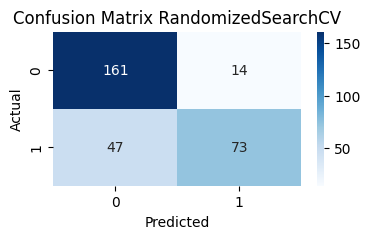

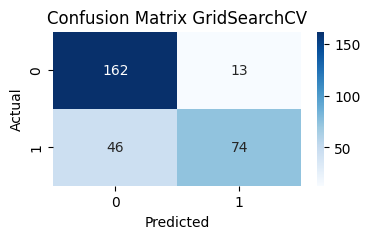

In [38]:
print('Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('Оценка точности модели при подборе параметров с помощью GridSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred_2)))

cm_2 = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(4, 2))
sns.heatmap(cm_2, annot=True, fmt=".0f", cmap='Blues')
plt.title('Confusion Matrix RandomizedSearchCV')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm_3 = confusion_matrix(y_test, y_pred_3)

plt.figure(figsize=(4, 2))
sns.heatmap(cm_3, annot=True, fmt=".0f", cmap='Blues')
plt.title('Confusion Matrix GridSearchCV')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [40]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [41]:
y_pred_tree = tree.predict(X_test)

In [42]:
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Точность дерева решений: {accuracy_tree:.4f}")

Точность дерева решений: 0.6610


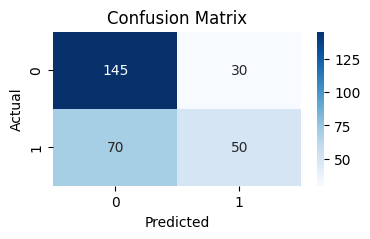

In [43]:
cm_4 = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(4, 2))
sns.heatmap(cm_4, annot=True, fmt=".0f", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

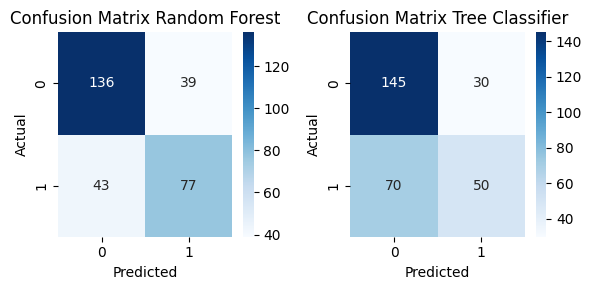

Точность леса решений : 0.7220
Точность дерева решений: 0.6610


In [44]:
def cm_all (y_test, y_pred_1, y_pred_tree):
    cm_1 = confusion_matrix(y_test, y_pred_1)
    cm_4 = confusion_matrix(y_test, y_pred_tree)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    sns.heatmap(cm_1, annot=True, fmt=".0f", cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix Random Forest')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm_4, annot=True, fmt=".0f", cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix Tree Classifier')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

cm_all(y_test, y_pred_1, y_pred_tree)

print('Точность леса решений : {0:0.4f}'. format(accuracy_score(y_test, y_pred_1)))
print(f"Точность дерева решений: {accuracy_tree:.4f}")

# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [ ]:
# Ваш код



# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



*   CRIM - уровень преступности на душу населения;
*   ZN - доля жилой застройки на участках площадью более 25 000 кв.футов;
*   INDUS - доля акров, не связанных с розничной торговлей в городе;
*   CHAS - фиктивная переменная, связанная с Charles River (= 1, если тракт граничит с рекой, в противном случае - 0);
*   NOX - концентрация оксида азота (частей на 10 миллионов);
*   RM - среднее количество комнат в доме;
*   AGE - доля квартир, занимаемых владельцами, построенных до 1940 года;;
*   DIS - расстояние до центра;
*   RAD - индекс доступности радиальных магистралей;
*   TAX - ставка налога на недвижимость по полной стоимости;
*   PTRATIO - cоотношение количества учеников и учителей в разбивке по городам;
*   MEDV - Средняя стоимость домов, занимаемых владельцами (в 1000$);
*   LSTAT - процент более низкого статуса населения;

In [47]:
from google.colab import files
uploaded = files.upload()
df_hd = pd.read_csv('/content/HousingData.csv')
df_hd.head()

Saving HousingData.csv to HousingData.csv


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [57]:
df_hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [58]:
df_hd.fillna(df_hd.mean(), inplace=True)

In [59]:
X = df_hd.drop(['MEDV'], axis=1)
y = df_hd['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((339, 13), (339,), (167, 13), (167,))

In [60]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10, random_state=1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [61]:
y_pred = rfr.predict(X_test)

In [62]:
# giving warning couz of value in squared=bool, but default=True
# if squared=True - gives the value of MSE(Mean Squared Deviation),
# else gives the value of RSE (Residual Standard Error)

from sklearn.metrics import mean_squared_error

mse_hd = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE модели RandomForestRegressor: {mse_hd:.4f}")

RMSE модели RandomForestRegressor: 3.3976


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


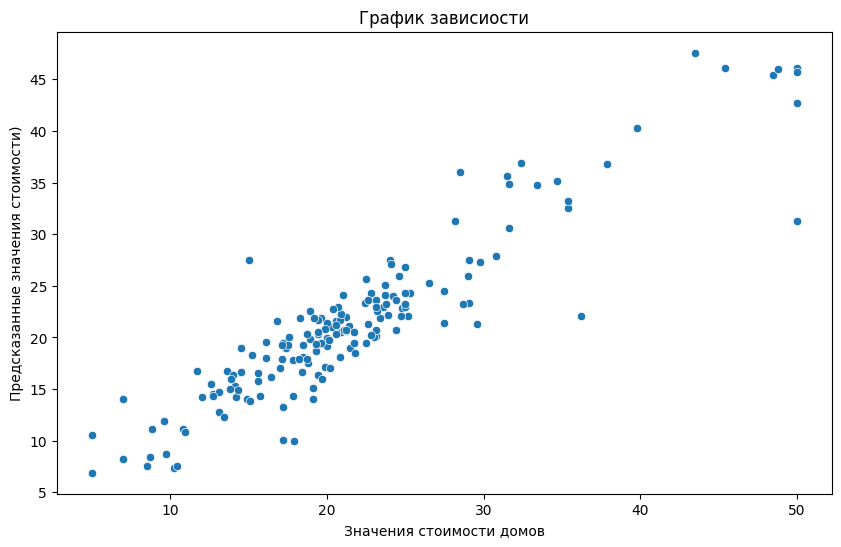

In [63]:
# Построение графика
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Значения стоимости домов')
plt.ylabel('Предсказанные значения стоимости)')
plt.title('График зависиости')
plt.show()

In [64]:
from sklearn.model_selection import RandomizedSearchCV

# Определяем список значений для параметра n_estimators (количество деревьев в лесу)
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# Определяем список значений для параметра max_depth (максимальная глубина дерева)
max_depth = [int(x) for x in np.linspace(3, 50, num=5)]
max_depth.append(None)  # Добавляем значение None для отсутствия ограничения глубины

# Определяем список значений для параметра max_leaf_nodes (максимальное количество листовых узлов)
max_leaf_nodes = [int(i) for i in range(1, 100)]

# Определяем пространство гиперпараметров для случайного поиска
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

# Создаем модель классификатора случайного леса с фиксированным random_state для воспроизводимости
rf_reg = RandomForestRegressor(random_state=1)

# Инициализируем RandomizedSearchCV для поиска оптимальных гиперпараметров
rf_cv = RandomizedSearchCV(
    estimator=rf_reg,                # модель для настройки
    param_distributions=random_grid, # словарь с параметрами для случайного поиска
    n_iter=100,                      # количество итераций (случайных наборов гиперпараметров)
    scoring='neg_mean_squared_error',              # метрика для оценки качества моделей
    cv=5,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    random_state=42,                 # фиксированный сид для воспроизводимости результатов
    n_jobs=-1                        # использование всех доступных ядер процессора
)

# Обучаем модель RandomizedSearchCV на обучающих данных с перебором гиперпараметров
rf_cv.fit(X_train, y_train)

# Получаем оптимальные гиперпараметры после поиска
rf_best_params = rf_cv.best_params_
print(f"Лучшие параметры: {rf_best_params}")

# Создаем новый классификатор случайного леса с оптимальными гиперпараметрами
rf_reg = RandomForestRegressor(**rf_best_params, random_state=1)

# Обучаем модель с оптимальными гиперпараметрами на обучающих данных
rf_reg.fit(X_train, y_train)

# Предсказываем классы для тестовых данных
y_pred = rf_reg.predict(X_test)

# Выводим оценку точности модели на тестовых данных
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Оценка качества модели при подборе параметров с помощью RandomizedSearchCV (RMSE): {rmse:.4f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Лучшие параметры: {'n_estimators': 100, 'max_leaf_nodes': 69, 'max_depth': 26}
Оценка качества модели при подборе параметров с помощью RandomizedSearchCV (RMSE): 3.1985


In [65]:
rfr_2 = RandomForestRegressor(n_estimators=100, max_leaf_nodes=69, max_depth=26, random_state=1)
rfr_2.fit(X_train, y_train)

RandomForestRegressor(max_depth=26, max_leaf_nodes=69, random_state=1)

In [66]:
y_pred_2 = rfr_2.predict(X_test)

In [67]:
mse_hd = mean_squared_error(y_test, y_pred_2, squared=False)
print(f"RMSE модели RandomForestRegressor: {mse_hd:.4f}")

RMSE модели RandomForestRegressor: 3.1985


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# нет предела совершенству